## Multivariate imputation of Chained Equations (MICE)

Now we will implement **MICE** using various machine learning models **to estimate the missing values**. [IterativeImputer from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer): Same model will be used to predict NA in all variables! **Can't use classification for binary variables and regression for continuous variables**! For a more sophisticated imputation, we would have to **assemble the imputers / models manually**!

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Load data

In [26]:
variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']
data = pd.read_csv('creditApprovalUCI.csv', usecols=variables)
data.head()

,A2,A3,A8,A11,A14,A15,A16
0,58.67,4.460,3.04,6,43.0,560,1
1,24.50,0.500,1.50,0,280.0,824,1
2,27.83,NaN,NaN,5,100.0,3,1
3,20.17,5.625,1.71,0,120.0,0,1
4,32.08,4.000,2.50,0,360.0,0,1


**Separate into training and testing set!**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((482, 6), (207, 6))

**Find the percentage of missing data within those variables!**

In [28]:
X_train.isnull().mean()

A2     0.016598
A3     0.141079
A8     0.141079
A11    0.000000
A14    0.022822
A15    0.000000
dtype: float64

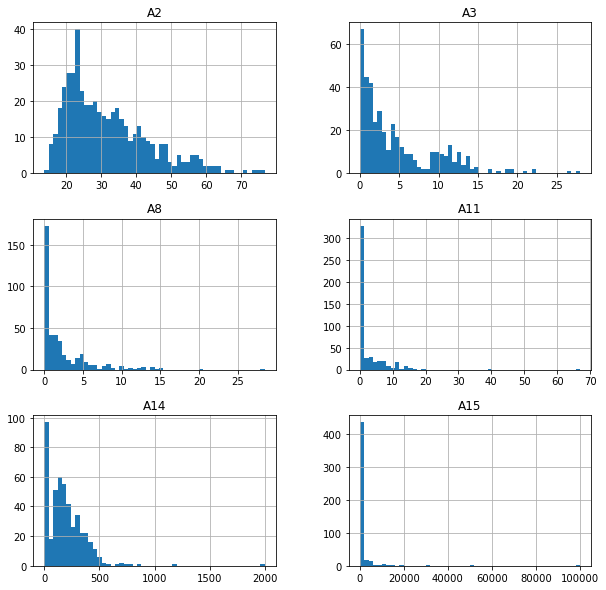

In [29]:
X_train.hist(bins=50, figsize=(10,10))
plt.show()

In this dataset, as most variables are **continuous**, we can **easily estimate missing values** with regression models using **MICE**.

**Create a MICE imputer using Bayes as estimator!**

In [30]:
imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,)

**Perform MICE!**

In [31]:
imputer.fit(X_train)

IterativeImputer(estimator=BayesianRidge(), random_state=0, skip_complete=True)

**Transform the data - replace the missing values!**

In [32]:
train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

**After the imputation there is no more data missing!**

In [33]:
pd.DataFrame(train_t, columns=X_train.columns).isnull().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

## Lets compare imputation with different models

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((482, 6), (207, 6))

In [36]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0)
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=10,
    random_state=0)
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
    max_iter=10,
    random_state=0)
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0)

In [37]:
imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

2022-01-29 20:27:02,611 [21124] WARNING  py.warnings:109: [JupyterRequire] C:\Users\husey\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"



IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                 random_state=0)

**Replace NA !**

In [38]:
X_train_bayes = imputer_bayes.transform(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_train_nonLin = imputer_nonLin.transform(X_train)
X_train_missForest = imputer_missForest.transform(X_train)

In [39]:
predictors = [var for var in variables if var !='A16']

**Transform numpy array to dataframe!**

In [40]:
X_train_bayes = pd.DataFrame(X_train_bayes, columns = predictors)
X_train_knn = pd.DataFrame(X_train_knn, columns = predictors)
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns = predictors)
X_train_missForest = pd.DataFrame(X_train_missForest, columns = predictors)

**Plot the distribution of the imputed variable!**

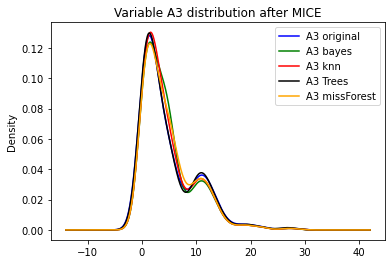

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['A3'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['A3'].plot(kind='kde', ax=ax, color='green')
X_train_knn['A3'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['A3'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['A3'].plot(kind='kde', ax=ax, color='orange')
lines, labels = ax.get_legend_handles_labels()  # add legends
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 Trees', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.title('Variable A3 distribution after MICE')
plt.show()